In [5]:
import sys
# sys.path.append("src/MoDE_embeddings/")
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pickle
from MoDE_embeddings.MoDE import MoDE
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn import datasets
from MoDE_embeddings.metrics import distance_metric, correlation_metric, order_preservation
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with open("parula_colormap.pkl", "rb") as f:
    p = pickle.load(f)

from matplotlib.colors import LinearSegmentedColormap

### loading the s_curve dataset

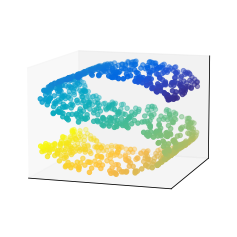

In [3]:
n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)
fig = plt.figure(figsize=(4, 6))

# Add 3d scatter plot
ax = fig.add_subplot(111, projection='3d')
parula_map = LinearSegmentedColormap.from_list('parula', p, N = n_points)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=parula_map)
ax.view_init(10, -72)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([]);

### Embedding with different methods

In [6]:
# MoDE
mode = MoDE(n_neighbor=10, max_iter=40000, tol=0.001, verbose=True)
x_2d_mode = mode.fit_transform(X, color)

# ISOMAP
isomap = Isomap(n_neighbors=10, n_components=2, tol=0.001)
x_2d_isomap = isomap.fit_transform(X)

# MDS
mds = MDS(eps=0.001, max_iter=3000)
x_2d_mds = mds.fit_transform(X)

# t-SNE
tsne = TSNE(n_components=2, perplexity=3.3, n_iter=3000, verbose=1)
x_2d_tsne = tsne.fit_transform(X)

# UMAP
import umap
reducer = umap.UMAP(n_neighbors=10, n_components=2)
x_2d_umap = reducer.fit_transform(X)

start
KNN graph computed.
Incidence matrix created 
Bounds on correlations computed.
end of GD algorithm
[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.072559
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.325348
[t-SNE] KL divergence after 3000 iterations: 0.378657


### visualizing embeddings

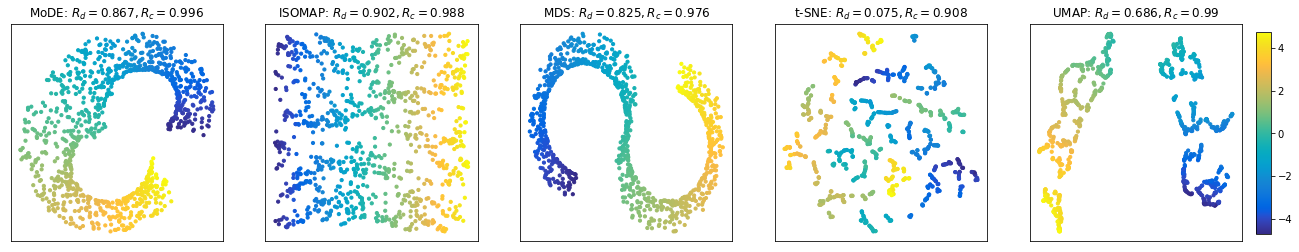

In [7]:
# colors = np.argsort(np.argsort(score.squeeze()))
marker_size = 10
fig, ax = plt.subplots(1,5, figsize=(20,4))
p1 = ax[0].scatter(x_2d_mode[:, 0], x_2d_mode[:,1], c=color, cmap=parula_map, s=marker_size)
R_d = distance_metric(X, x_2d_mode, n_neighbor=10)
R_c = correlation_metric(X, x_2d_mode, n_neighbor=10)
ax[0].set_title("MoDE: $R_d={}, R_c={}$".format(np.round(R_d, 3), np.round(R_c, 3)))


p2 = ax[1].scatter(x_2d_isomap[:, 0], x_2d_isomap[:,1], c=color, cmap=parula_map, s=marker_size)
R_d = distance_metric(X, x_2d_isomap, n_neighbor=10)
R_c = correlation_metric(X, x_2d_isomap, n_neighbor=10)
ax[1].set_title("ISOMAP: $R_d={}, R_c={}$".format(np.round(R_d, 3), np.round(R_c, 3)))


p3 = ax[2].scatter(x_2d_mds[:, 0], x_2d_mds[:,1], c=color, cmap=parula_map, s=marker_size)
R_d = distance_metric(X, x_2d_mds, n_neighbor=10)
R_c = correlation_metric(X, x_2d_mds, n_neighbor=10)
ax[2].set_title("MDS: $R_d={}, R_c={}$".format(np.round(R_d, 3), np.round(R_c, 3)))


p4 = ax[3].scatter(x_2d_tsne[:, 0], x_2d_tsne[:,1], c=color, cmap=parula_map, s=marker_size)
R_d = distance_metric(X, x_2d_tsne, n_neighbor=10)
R_c = correlation_metric(X, x_2d_tsne, n_neighbor=10)
ax[3].set_title("t-SNE: $R_d={}, R_c={}$".format(np.round(R_d, 3), np.round(R_c, 3)))


p5 = ax[4].scatter(x_2d_umap[:, 0], x_2d_umap[:,1], c=color, cmap=parula_map, s=marker_size)
R_d = distance_metric(X, x_2d_umap, n_neighbor=10)
R_c = correlation_metric(X, x_2d_umap, n_neighbor=10)
ax[4].set_title("UMAP: $R_d={}, R_c={}$".format(np.round(R_d, 3), np.round(R_c, 3)))

fig.subplots_adjust(right=0.98)
cbar_ax = fig.add_axes([0.99, 0.15, 0.01, 0.7])
cbar = fig.colorbar(p5, cax=cbar_ax)
# remove the x and y ticks
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
# plt.savefig("figures/ESG.jpg", dpi=1200);
plt.show();

### Embedding compressed data with MoDE

In [12]:
# In this section we use the small stock dataset.
data = loadmat("../MATLAB_implementation/data/small_stock.mat")["StockData"]
score = loadmat("../MATLAB_implementation/data/small_stock.mat")["Score"]

In [13]:
#normalize
m = np.mean(data, axis=1)
data = data - m.reshape((-1,1))

s = np.max(data, axis=1) - np.min(data, axis=1)
data = data / s.reshape((-1,1))

In [14]:
# compute the upper and lower bound on distances
from waterfilling_compression import WaterfillingCompression
comp = WaterfillingCompression(num_coeffs=4)
start = time.time()
dm_ub, dm_lb = comp.compute_distance_bounds(data)
print(time.time() - start)

75.92267632484436


In [15]:
dm_ub = np.round(dm_ub, decimals=5)
dm_lb = np.round(dm_lb, decimals=5)

In [16]:
mode = MoDE(n_neighbor=20, max_iter=100000, tol=0.0001, verbose=True)
start = time.time()

x_2d_mode = mode.fit_transform(data, score.squeeze(), dm_ub, dm_lb)

print("time: ", time.time() - start)

0.007246376811594203
Start of Gradient Descent algorithm
0 out of 100000 iterations has passed
10000 out of 100000 iterations has passed
20000 out of 100000 iterations has passed
30000 out of 100000 iterations has passed
GD stopped after 32000 iteration
end of GD algorithm
time:  16.480719327926636


In [17]:
dm_avg = dm_lb + dm_ub / 2
print("R_d:", distance_metric(data, x_2d_mode, n_neighbor=10, dm=dm_avg))
print("R_c:", correlation_metric(data, x_2d_mode, n_neighbor=10, dm=dm_avg))
print("R_o:", order_preservation(data, mode.P, n_neighbor=10, score=color.squeeze(), dm=dm_avg))

R_d: 0.7015340789395715
R_c: 0.8494370106205993
R_o: 0.5153562653562653


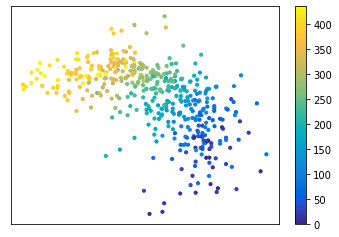

In [19]:
colors = np.argsort(np.argsort(score.squeeze()))
plt.scatter(x_2d_mode[:, 0], x_2d_mode[:,1], c=colors, cmap=parula_map, s=marker_size)
plt.xticks([])
plt.yticks([])
plt.colorbar();